## Linear Discriminant Analysis (LDA)
: 규제가 없는 모델에서 차원의 저주로 인한 과대 적합 정도를 줄이고 계산 효율성을 높이기 위한 특성 추출의 기법

- PCA는 비지도인 반면, LDA는 지도 학습 알고리즘
- PCA가 데이터셋에 있는 분산이 최대인 직교 성분 축을 찾으려고 함
- 반면, LDA 목표는 클래스를 최적으로 구분할 수 있는 특성 부분 공간을 찾는 것임

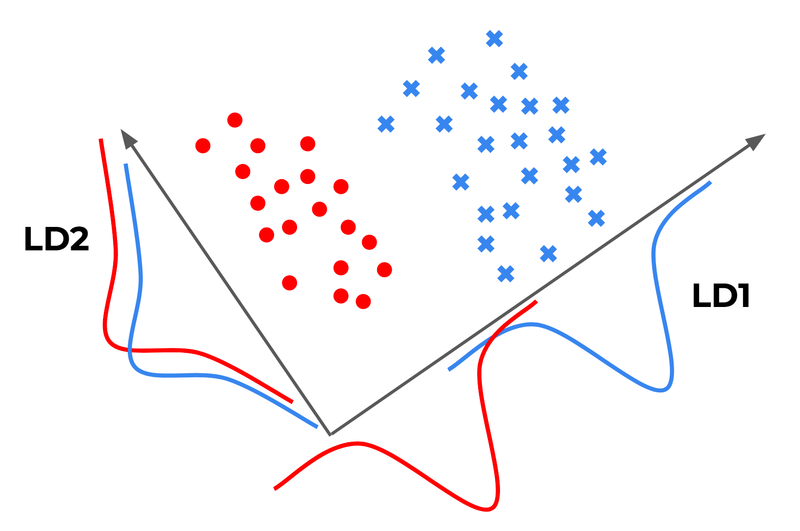
출처: https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=pmw9440&logNo=221574212339

### <LDA 분석의 단계>

1. d차원의 데이터셋 표준화 전처리 (d는 특성 개수)


2. 각 클래스에 대해 d차원의 평균 벡터 계산


3. 클래스 간의 산포 행렬(scatter matrix) $S_B$와 클래스 내 산포 행렬 $S_W$를 구성


4. $S_W^-1S_B$ 행렬의 고유 벡터와 고윳값을 계산


5. 고윳값을 내림차순으로 정렬하여 고유 벡터의 순서 매김


6. 고윳값이 가장 큰 k개의 고유 벡터를 선택하여  dxk차원의 변환 행렬 *W*를 구성


7. 변환 행렬 *W*를 사용하여 샘플을 새로운 특성 부분 공간으로 투영


In [1]:
# 기본 데이터 분석을 위한 Library
import pandas as pd
import numpy as np

# 시각화 Library
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn에 있는 기본 데이터셋을 가져오기 위한
from sklearn import datasets

from sklearn.model_selection import train_test_split

In [2]:
## 데이터 불러오기
df_wine = datasets.load_wine()
X, y = df_wine['data'], df_wine['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

### 1. 산포 행렬 계산

In [3]:
### 1. 데이터 표준화
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [18]:
### 2.평균 벡터 계산
np.set_printoptions(precision=4) # 소수 넷째 자리까지 반올림
mean_vecs = []
for label in range(0,3):
    mean_vecs.append(np.mean(
    X_train_std[y_train==label], axis=0))
    print('MV {0}:{1}\n'.format(label,mean_vecs[label]))

MV 0:[ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075]

MV 1:[-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253]

MV 2:[ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013]



In [22]:
### 3. 클래스 간 산포 행렬(S_B)과 클래스 내 산포 행렬(S_W) 구성
d = 13 # 특성 개수
S_W = np.zeros((d,d))
for label, mv in zip(range(0,3), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row-mv).dot((row-mv).T) # 개별 클래스 i의 산포 행렬 S_i
    S_W += class_scatter # 클래스 내 산포 행렬 S_W

print('클래스 내의 산포 행렬:{0}x{1}'.format(S_W.shape[0], S_W.shape[1]))

클래스 내의 산포 행렬:13x13


In [24]:
mean_overall = np.mean(X_train_std, axis=0) # 전체 평균
mean_overall = mean_overall.reshape(d,1) # 열 벡터로 만들기
d = 13 # 특성 개수
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n  = X_train[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d,1) # 열 벡터로 만들기
    S_B += n * (mean_vec - mean_overall).dot(
                (mean_vec - mean_overall).T)
    
print('클래스 간의 산포 행렬:{0}x{1}'.format(S_B.shape[0], S_B.shape[1]))

클래스 간의 산포 행렬:13x13


### 2. 새로운 특성 부분 공간을 위한 선형 판별 벡터 선택

In [38]:
### 1. 산포행렬의 곱으로 된 행렬로 고윳값과 고유 벡터 구하기
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i])
              for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs,
                    key=lambda k: k[0], reverse=True)

print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

8.262493673957485
4.225659486916686
8.881784197001252e-16
8.764745429304463e-16
8.764745429304463e-16
5.980436696318132e-16
5.980436696318132e-16
4.725972363858591e-16
4.204321571482643e-16
1.2897675438347564e-16
1.2897675438347564e-16
1.0790021912531504e-16
5.247386496939438e-17


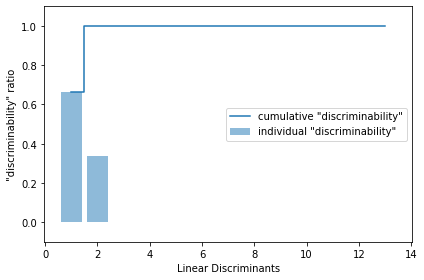

In [31]:
'''처음 두 개의 선형 판별 벡터가 Wine 데이터셋에 있는 정보를 거의 100% 잡아냄.'''
tot = sum(eigen_vals.real) # complex arg에서 real part만
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr) # 누적합
plt.bar(range(1,14), discr, alpha=0.5, align='center', 
       label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid',
        label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1, 1.1])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [35]:
### 2. 최상위 k개의 고유 벡터로 변환 행렬 W를 만듦 (k=2)
W = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
              eigen_pairs[1][1][:, np.newaxis].real))
print('행렬 W:\n', W) # 변환행렬 W

행렬 W:
 [[-0.1586 -0.4077]
 [ 0.0984 -0.1821]
 [-0.0156 -0.3473]
 [ 0.1588  0.3095]
 [-0.0207 -0.064 ]
 [ 0.1884  0.0733]
 [-0.7153  0.3034]
 [-0.0798 -0.0009]
 [ 0.0074  0.0716]
 [ 0.3448 -0.2808]
 [-0.0254  0.244 ]
 [-0.3192 -0.0459]
 [-0.4054 -0.5806]]


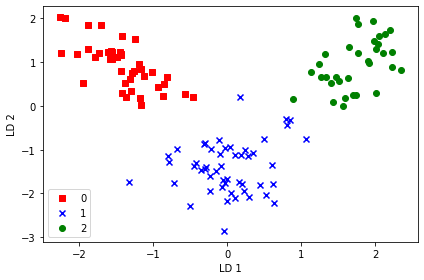

In [37]:
### 3. 변환 행렬 W를 사용하여 d차원을 k차원으로 변환 (시각화)
X_train_lda = X_train_std.dot(W)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
               X_train_lda[y_train==l, 1] * (-1),
               c=c, label=l, marker=m)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()